In [1]:
from ROOT  import * #En el ICN no funciona

Welcome to JupyROOT 6.26/06


# Llenar un histograma y hacer fit
## usando pyROOT

 FCN=116.6 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=3.06448e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     9.81582e+01   1.75014e+00   7.43780e-03  -3.39899e-04
   2  Mean         9.63500e-03   1.44047e-02   7.62630e-05  -1.70389e-02
   3  Sigma        9.94926e-01   1.08268e-02   1.52413e-05   6.11024e-02


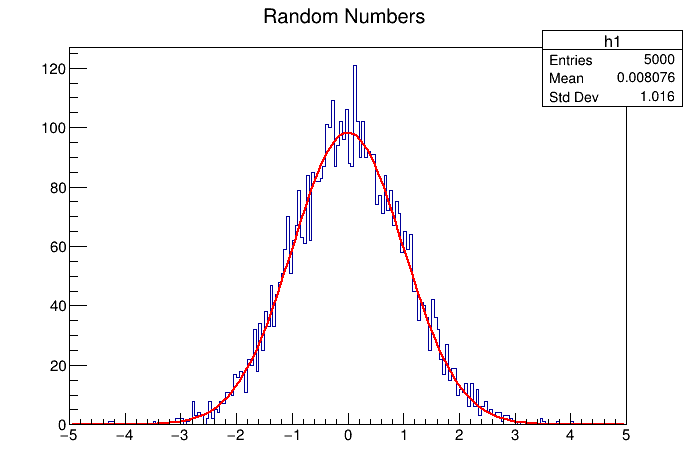

In [2]:
h1=TH1F("h1", "Random Numbers",200,-5,5)

data=h1.FillRandom("gaus")

c1=TCanvas()

h1.Fit("gaus")

h1.Draw()
c1.Draw()

### Obtener mas resultados acerca del ajuste

In [3]:
f = h1.GetFunction("gaus")
print(f.GetNDF())           # Numero de grados de libertad
print(f.GetChisquare())     # Chisquare
print(f.GetProb())          # 

127
116.59974682218747
0.7353736867937091


## Utilizando datos de una imagen FITS

In [4]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

import sys

sys.path.insert(0, '/home/mauricio/Software/Serial_Register_Events_Detection')
from ReconLib import *

plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth":2,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})


Filename: /home/mauricio/datosFits/spuriousCharge/Microchip/14AUG23/proc_skp_module24_MITLL01_externalVr-4_Vv2_T140__NSAMP225_NROW650_NCOL700_EXPOSURE0_NBINROW1_NBINCOL1_img109.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   (700, 650)   float32   
  1                1 ImageHDU       164   (700, 650)   float32   
  2                1 ImageHDU       164   (700, 650)   float32   
  3                1 ImageHDU       164   (700, 650)   float32   
None
----------------


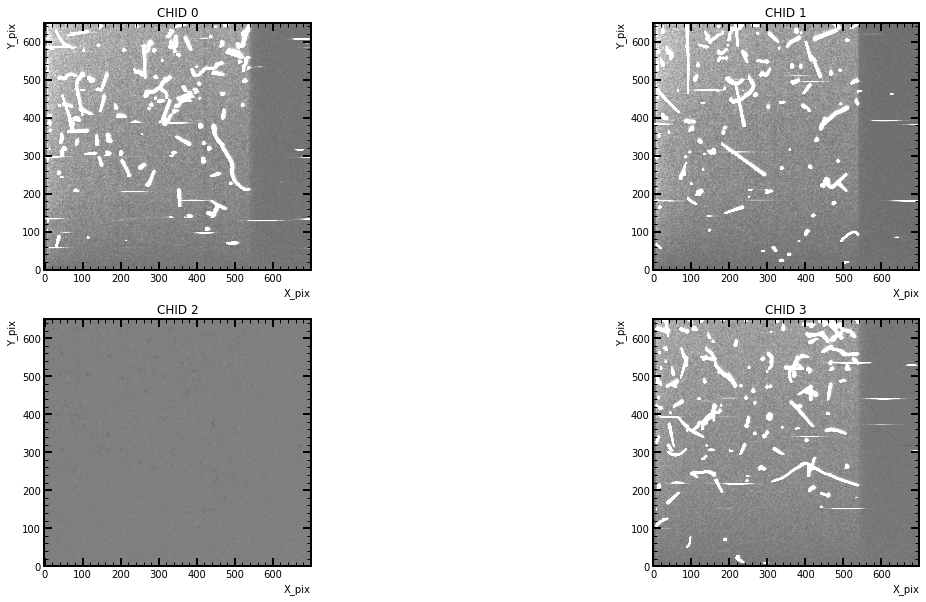

In [5]:
path='/home/mauricio/datosFits/spuriousCharge/Microchip/14AUG23/proc_skp_module24_MITLL01_externalVr-4_Vv2_T140__NSAMP225_NROW650_NCOL700_EXPOSURE0_NBINROW1_NBINCOL1_img109.fits'
hdu_list = fits.open(path)
print(hdu_list.info())
print('----------------')
# hdu_list[0].header
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(hdu_list[i].data-np.median(hdu_list[i].data),vmin=-800,vmax=800,cmap='gray')
    plt.title('CHID '+str(i))
    plt.ylabel('Y_pix')
    plt.xlabel('X_pix')
plt.show()

## En este ejemplo seleccionaremos el area de OS y aplicamos el algoritomo J_Guerra para enmascarar eventos de registro serial

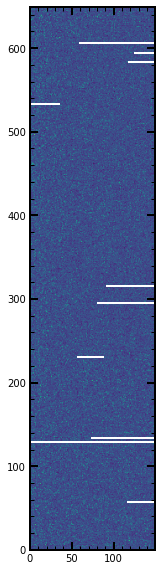

In [6]:
serialRegisterEvents_n5, CCDMask, _, _=makeSerialRegisterEventAdvancedMask(hdu_list[0].data,n = 5,extend=True,overscan=550,frames=15)

la_mascara=np.ma.masked_array(hdu_list[0].data, mask=serialRegisterEvents_n5)
ROI=la_mascara[:,550:]
plt.figure(figsize=(10,10))
plt.imshow(ROI)
flatROI=ROI.flatten()

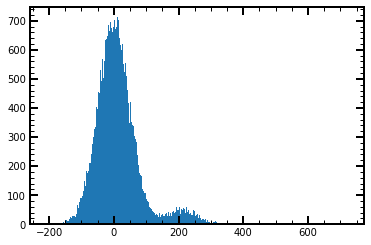

In [13]:
histo, bins,_ = plt.hist(flatROI, bins=1000)

## La distribucion de pixeles que esperamos es una doble gaussiana, de la cual tenemos una curva que hemos utilizado anteriormente y que podemos definir en ROOT para poder utilizarla en el fit

In [7]:
# definition and parameters of gaussian2: 
# def gaussian2(x,m,s,g,a1,a2): #data, mean = [0] , sigma = [1], gain =[2], height1 = [3], heigth2 = [4]
# in root format: [3]*exp(-1/2*((x-[0])/[1])^2)+[4]*exp(-1/2*((x-[0]-[2])/[1])^2)

def gaussian2(x,m,s,g,a1,a2): #data, mean, sigma, gain, height1, heigth2
    return a1*np.exp(-1/2*((x-m)/s)**2)+a2*np.exp(-1/2*((x-m-g)/s)**2)    #esta funcion la usé en python para un ajuste de dos gausianas, 
                                                                          # solo es necesario escribir la funcion de manera compatible con ROOT
# https://root.cern.ch/root/htmldoc/guides/users-guide/FittingHistograms.html
#data, mean = [0] , sigma = [1], gain =[2], height1 = [3], heigth2 = [4]

## Definicion de la variable TFunction 
fgaus2 = TF1("fgauss2","[3]*exp(-0.5*((x-[0])/[1])^2)+[4]*exp(-0.5*((x-[0]-[2])/[1])^2)",-200,700,5) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)


chiSquare= 850.4110356069917
NDegrees of Freedom: 720
 FCN=850.411 FROM MIGRAD    STATUS=CONVERGED     114 CALLS         115 TOTAL
                     EDM=1.40595e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -4.27982e-01   1.70687e-01   2.40007e-03   6.03914e-04
   2  p1           4.95614e+01   1.22209e-01   1.37579e-03   3.30338e-04
   3  p2           2.10371e+02   7.70801e-01   1.06994e-02  -5.83195e-04
   4  p3           6.79559e+02   2.79822e+00   3.24097e-02  -7.17555e-06
   5  p4           4.75839e+01   6.59793e-01   8.92897e-03   2.91792e-04


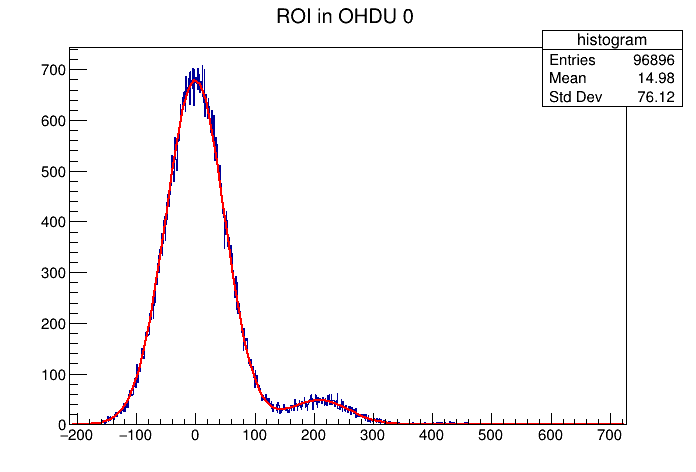

In [14]:
h3=TH1F("histogram", "ROI in OHDU 0",1000, flatROI.min(),flatROI.max())

for pixel_value in flatROI:
    if not np.ma.is_masked(pixel_value):
        h3.Fill(pixel_value)
        #print(pixel_value)

fgaus2.SetParameters(0,50,200,700,50) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h3.Fit(fgaus2)

c3=TCanvas()

h3.Draw()
c3.Draw()
#fgaus2.Draw("same")

print("chiSquare= "+str(fgaus2.GetChisquare()))
print("NDegrees of Freedom: "+str(fgaus2.GetNDF()))



